# Investigating Fraud from Enron Email Dataset

#### By Huong Ivy Nguyen

## Introduction:

The name ‘Enron’ for this project came from the famous scandal ‘Enron scandal’  in the corporate world. It was also the name of an American energy, commodities, and services company based in Houston, Texas, Enron Corporate. Enron Corporation was founded in 1985 by Kenneth Lay after merging Houston Natural Gas and InterNorth before its bankruptcy on December 2, 2001.  After a a thorough investigation, it was revealed that the financial conditions of Enron was ran by institutionalized systematic planned accountant fraud, which is now known as the Enron scandal. This investigation also left behind a public large dataset of the company’s emails, which is known as the Enron Corpus. 
In this project, the emails and financial data of 146 executives will be investigated in order to identify the person of interest (POI) in the Enron fraud. A POI is defined as someone either was indicted for fraud, settled with the government, or testified in exchange for immunity.  
In summary, there are 4 major steps in the overall project:
+ Data exploration: identify and remove outliers
+ Feature processing
+ Algorithm Development
+ Validation 

## Data Exploration

To start, I would like to import all the necessary packages for the data analysis. 

In [1]:
import random
random.seed(123456789)
import os
os.chdir('/home/ives/Documents/ud_machine_learning/ud120-projects/final_project/')

from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
import pickle
import numpy as np
import pandas as pd
from time import time
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


sys.path.append("../tools/")

from feature_format import featureFormat
from feature_format import targetFeatureSplit

/home/ives/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ives/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
### Load Enron dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))

In [3]:
### Checking how many keys the dataset has
print "There are", len(data_dict), "executives in the Enron dataset."

### Checking how many features each key has using 'ALLEN PHILLIP K' as a key.
print "There are", len(data_dict['ALLEN PHILLIP K']), "features associated with each key in the Enron dictionary dataset."

### Checking how many data points were marked as POI and non-POI
poi_list = 0
non_poi_list = 0
for key in data_dict:
    if data_dict[key]['poi']:
        poi_list +=1
    else:
        non_poi_list +=1
        
print "\nOf 146 records,", poi_list, "were labeled as person of interest (POI) and", non_poi_list, "were not labeled as POI."

### Checking which features have NaN values:
nan_features = []
for key in data_dict:
    for feature in data_dict[key]:
        if data_dict[key][feature] == 'NaN':
            nan_features.append(feature)
nan_features = set(nan_features)

print "\nFeatures with NaN values are:"
for feature in nan_features:
    print " +", feature

There are 146 executives in the Enron dataset.
There are 21 features associated with each key in the Enron dictionary dataset.

Of 146 records, 18 were labeled as person of interest (POI) and 128 were not labeled as POI.

Features with NaN values are:
 + salary
 + to_messages
 + deferral_payments
 + total_payments
 + long_term_incentive
 + loan_advances
 + bonus
 + restricted_stock
 + restricted_stock_deferred
 + total_stock_value
 + shared_receipt_with_poi
 + from_poi_to_this_person
 + exercised_stock_options
 + from_messages
 + other
 + from_this_person_to_poi
 + deferred_income
 + expenses
 + email_address
 + director_fees


Since the ratio between POI and non-POI is highly skewed (18/128), class imbalance will be especially problematic when creating classification models for this dataset. This is because most machine learning algorithms work best when the number of classes are equivalent. Beyond that, there are 20 out of 21 features that have missing values. These features need special attention when processing the dataset. 

### Outliers Removal

First, I would like to have a look at the correlation between two features: salary and bonus to identify if there is any outlier. If there are outliers, they will need to be removed before the data analysis can proceed further. 

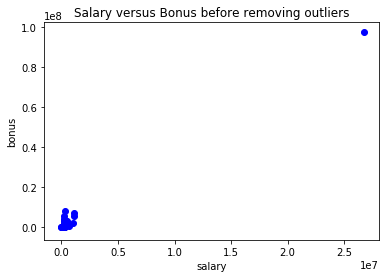

In [4]:
features = ['salary', 'bonus']
data = featureFormat(data_dict, features)

### Create scatter plot
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus, color = 'blue')

plt.xlabel("salary")
plt.ylabel("bonus")
plt.title("Salary versus Bonus before removing outliers")

After plotting salary versus bonus, I noticed there are outliers within the dataset. This data point is way out of the regular range for both salary and bonus. This data point is actually the 'TOTAL' row in the spreadsheet, which is not necessary to be included in the dataset during my data analysis. So I chose to remove it and create my scatter plot again.

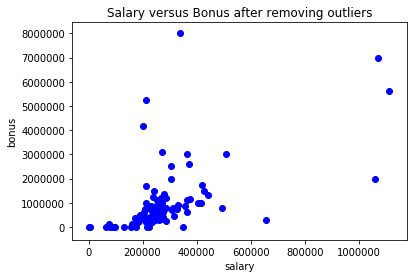

In [5]:
data_dict.pop("TOTAL",0)
new_data = featureFormat(data_dict, features)

### Create scatter plot
for point in new_data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus, color = 'blue')

plt.xlabel("salary")
plt.ylabel("bonus")
plt.title("Salary versus Bonus after removing outliers")

After removing "TOTAL" as an outlier out of my original dataset, I noticed that the new scatter plot now has additional outliers which have either a large salary or a large bonus. These outliers could potentially imply something else within the dataset (fraud detection) rather than just simply errors during the data entry process. In order to further investigate this fact, I extracted these 4 data points to see who they are represented. 

In [6]:
outliers = []

###remove all NaN data points
for key in data_dict:
    val1 = data_dict[key]['salary']
    val2 = data_dict[key]['bonus']
    if val1 != 'NaN' and val2 != 'NaN':
        outliers.append((key,val1,val2))

outliers_final_salary = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
outliers_final_bonus = (sorted(outliers,key=lambda x:x[2],reverse=True)[:4])
### print top 4 salaries and top 4 bonuses
print outliers_final_salary
print outliers_final_bonus

[('SKILLING JEFFREY K', 1111258, 5600000), ('LAY KENNETH L', 1072321, 7000000), ('FREVERT MARK A', 1060932, 2000000), ('PICKERING MARK R', 655037, 300000)]
[('LAVORATO JOHN J', 339288, 8000000), ('LAY KENNETH L', 1072321, 7000000), ('SKILLING JEFFREY K', 1111258, 5600000), ('BELDEN TIMOTHY N', 213999, 5249999)]


After looking at my top 4 salaries and top 4 bonuses, I noticed Kenneth Lay and Jeffrey Skilling both have really high salaries and bonuses. In addition to these two, while Mark Frevert and Mark Pickering have an extremely high salary, John Lavorato and Timothy Belden are the ones with a ridiculous amount of bonuses. As I looked up what their roles were in Enron, I realized that these data points are not indeed mistakes since Kenneth Lay and Jeffrey SKilling both hold high positions within the company. That fact confirms that these values are real and actually they are already a sign of these two managers being involved in the fraud. 

## Feature Processing

After cleaning my dataset from outliers, I had to pick the most sensible features to use. I picked 'from_poi_to_this_person' and 'from_this_person_to_poi' to generate a scatter plot in order to determine if there is any strong correlation between these two features. 

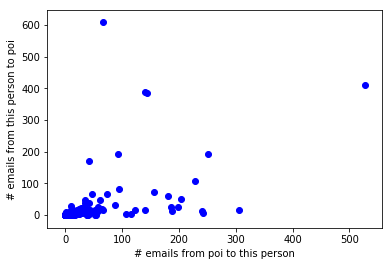

In [7]:
for key in data_dict:
    val1 = data_dict[key]['from_poi_to_this_person']
    val2 = data_dict[key]['from_this_person_to_poi']
    plt.scatter(val1, val2, color = 'blue')
plt.xlabel('# emails from poi to this person')
plt.ylabel('# emails from this person to poi')

There isn't a strong correlation that was obtained from the 'from_poi_to_this_person' and 'from_this_person_to_poi' features so I had to create new features. I chose to use fractions for both features of “from/to poi messages” and “total from/to messages” as my new generated features for this dataset.The new features are named:
+ fraction_to_poi_email, which was calculated by dividing the 'from_this_person_to_poi' by 'from_messages'
+ fraction_from_poi_email, which was calculated by diviing the 'from_poi_to_this_person' by "to_messages'

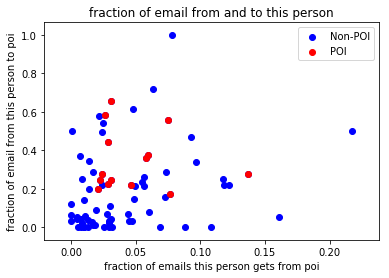

In [8]:
### define normalizing function to create new features
def normalizing(key, normalizer):
    new_list = []
    for point in data_dict:
        if data_dict[point][key] == 'NaN' or data_dict[point][normalizer] == 'NaN':
            new_list.append(0.)
        else:
            new_key = float(data_dict[point][key])/float(data_dict[point][normalizer])
            new_list.append(new_key)
    return new_list

### Create new features: fraction_to_poi_email,fraction_from_poi_email
fraction_from_poi_email = normalizing('from_poi_to_this_person', 'to_messages')
fraction_to_poi_email = normalizing('from_this_person_to_poi', 'from_messages')

### insert new features into data_dict
count = 0
for key in data_dict:
    data_dict[key]['fraction_from_poi_email'] = fraction_from_poi_email[count]
    data_dict[key]['fraction_to_poi_email'] = fraction_to_poi_email[count]
    count +=1

features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    

### Create new dataset with the specified feature, the returned result should be a numpy array
new_data_with_fraction = featureFormat(data_dict, features_list)

### plot new features
from_poi = []
to_poi = []
poi_x = []
poi_y = []
for point in new_data_with_fraction:
    from_poi.append(point[1])
    to_poi.append(point[2])
    if point[0] == 1: #Identify the poi on the plot versus with other points
        poi_x.append(point[1])
        poi_y.append(point[2])

fig, ax = plt.subplots()
ax.scatter(from_poi, to_poi, label='Non-POI', color = 'blue')
ax.scatter(poi_x, poi_y, label='POI', color = 'red')      
plt.xlabel("fraction of emails this person gets from poi")
plt.ylabel("fraction of email from this person to poi")
plt.title("fraction of email from and to this person")  
plt.legend()
plt.show()

In order to find the most effective features for identifying the POI, feature selection process was completed using Decision Tree classifier. The importance of each feature is calculated and ranked. Some of the features were omitted since they don't provide any extra information such as others. Features that were used to calculated other features such as to_messages or from_messages were also omitted. 

In [9]:
### The following features were omitted: others, to_messages, from_messages, from_poi_to_this_person, 
### from_this_person_to_poi, email_addresses. 

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                     'restricted_stock_deferred','deferred_income', 'total_stock_value','expenses', 
                     'exercised_stock_options','long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['shared_receipt_with_poi']

new_features = ['fraction_from_poi_email', 'fraction_to_poi_email']
    
features_list = ['poi'] + financial_features + email_features + new_features ### Add poi as the first feature for later splitting purpose

###Generate a numpy array data with all the listed features using FeatureFormat function

data = featureFormat(data_dict, features_list)

### Split the generated numpy array data into labels and features using targetFeatureSplit
### The first feature in the array must be the poi label since targetFeatureSplit assumes that is the target while
### the others are features that are used to predict the labels

labels, features = targetFeatureSplit(data)

### Split data into training and testing datasets using 10% as benchmark
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size = 0.1, random_state = 42)

### Generate a decision tree classifier
from sklearn.tree import DecisionTreeClassifier

t0 = time() #Timing the classification process

clf = DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

t1 = time() - t0
print "Decision tree algorithm time:", round(t1, 3), "s"

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pred, labels_test)
print "Accuracy is", accuracy
### Rank features based on their importance, which is computed as the total reduction of the criterion 
### brought by that particular feature.

importances = clf.feature_importances_

importances_list = []
count = 0
features = financial_features + email_features + new_features

for feature in features:
    importances_list.append((feature,importances[count]))
    count +=1

new_importances_list = sorted(importances_list, key=lambda x:x[1], reverse=True)
for i in new_importances_list:
    print i

Decision tree algorithm time: 0.001 s
Accuracy is 0.6
('shared_receipt_with_poi', 0.18161490683229806)
('fraction_to_poi_email', 0.15829098437794106)
('deferred_income', 0.14622972934993392)
('total_stock_value', 0.12090173025732028)
('deferral_payments', 0.11833731485905398)
('restricted_stock', 0.091127677779186206)
('expenses', 0.087979539641943674)
('exercised_stock_options', 0.074533201196910162)
('total_payments', 0.02098491570541262)
('salary', 0.0)
('loan_advances', 0.0)
('bonus', 0.0)
('restricted_stock_deferred', 0.0)
('long_term_incentive', 0.0)
('director_fees', 0.0)
('fraction_from_poi_email', 0.0)


Using the results obtained from the importance list, I picked the following features: excercised_stock_options, fraction_to_poi_email,deferred_income, expenses, deferral_payments, shared_receipt_with_poi, bonus, restricted_stock, and salary. The accuracy for this set is 0.8 as shown below.

In [10]:
new_features_list = ['poi', 'exercised_stock_options', 'fraction_to_poi_email', 'deferred_income','expenses',
                    'deferral_payments', 'shared_receipt_with_poi', 'bonus', 'restricted_stock', 'salary']

data = featureFormat(data_dict, new_features_list)

labels, features = targetFeatureSplit(data)

### Split data into training and testing datasets using 10% as benchmark
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size = 0.1, random_state = 42)

### Generate a decision tree classifier
from sklearn.tree import DecisionTreeClassifier

t0 = time() #Timing the classification process

clf = DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

t1 = time() - t0
print "Decision tree algorithm time:", round(t1, 3), "s"

from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(pred, labels_test)
precision = precision_score(pred, labels_test)
recall = recall_score(pred, labels_test)
print "Accuracy is", accuracy
print "Precision is", precision
print "Recall is", recall

Decision tree algorithm time: 0.001 s
Accuracy is 0.866666666667
Precision is 0.0
Recall is 0.0


Even though my accuracy was increased by using this new feature set, my precision and recall scores are very low, which means my classifier needs further attention in term of choosing the correct features. From here, I cannot rely on accuracy score for my dataset; instead, I chose to use SelectKBest from feature_selection module to select the best features for my classifier. In order to optimize what the best k value to use for SelectKBest, several k values were used to choose the number of features needed.

/home/ives/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


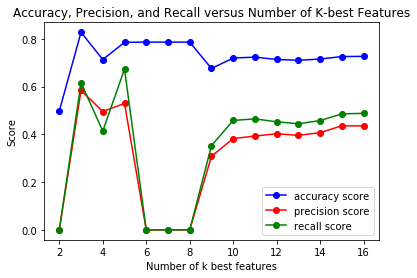

In [11]:
from sklearn.feature_selection import SelectKBest

### define k_best function
def get_k_best(data_dict, features_list, k):
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)
    
    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(sorted(unsorted_pairs, key=lambda x: x[1], reverse=True))
    k_best_features = dict(sorted_pairs[:k])
    return k_best_features

### Optimize k value
k_values = range(2,17,1)
accuracy_scores = []
precision_scores = []
recall_scores = []

for k in k_values:
    precisions = []
    accuracies = []
    recalls = []
    for i in range(1000):
        k_best = get_k_best(data_dict, features_list, k)
        new_features = ['poi'] + list(k_best.keys())
        data = featureFormat(data_dict, new_features)
        labels, features = targetFeatureSplit(data)
        features_train, features_test, labels_train,\
        labels_test = cross_validation.train_test_split(features, labels, test_size = 0.1, random_state = 42)
        clf.fit(features_train, labels_train)
        predict = clf.predict(features_test)
        accuracy = accuracy_score(predict, labels_test)
        precision = precision_score(predict, labels_test)
        recall = recall_score(predict, labels_test)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    accuracy_scores.append(np.mean(accuracies))
    precision_scores.append(np.mean(precisions))
    recall_scores.append(np.mean(recalls))

fig, ax = plt.subplots()
ax.plot(k_values, accuracy_scores, label = "accuracy score", color = 'blue', marker ='o')
ax.plot(k_values, precision_scores, label = "precision score", color = 'red', marker = 'o')
ax.plot(k_values, recall_scores, label = "recall score", color = "green", marker = 'o')
     
plt.xlabel("Number of k best features")
plt.ylabel("Score")
plt.title("Accuracy, Precision, and Recall versus Number of K-best Features")  
plt.legend()
plt.show()

According to the generated plot above (Accuracy, Precision, and Recall versus Number of K-best features), the highest precision and recall scores would be obtained when using either k=3, k=5, or k in the range from 10 to 15. I chose to use k=10 to establish a new feature set.

In [12]:
k_best = get_k_best(data_dict, features_list, 10)
new_features = ['poi'] + list(k_best.keys())
data = featureFormat(data_dict, new_features)

###Create label and feature sets, these sets will be used for the rest of the project
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train,labels_test = cross_validation.train_test_split(features, labels, test_size = 0.1)
clf = DecisionTreeClassifier()
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
accuracy = accuracy_score(predict, labels_test)
precision = precision_score(predict, labels_test)
recall = recall_score(predict, labels_test)

print "New accuracy score is", accuracy
print "New precision score is", precision
print "New recall score is", recall

New accuracy score is 0.666666666667
New precision score is 0.5
New recall score is 0.2


## Algorithm and Tunning
### Choosing an algorithm

I decided to test 5 different algorithms Naive Bayes,Decision Tree, KMean Cluserting, Adaboost, and SVM to determine which one would be best for my dataset. After finding out the best algorithm to use, I tuned their behavior with different parameters such as n_clusters and max_iter in the case of KMeans.

Parameter tunning is important and necessary since this process can help to improve the performance of the algorithm significantly. In an abstract sense of machine learning, tuning is considered as working with the datatset while using different parameters that were previously defined in the algorithm to obtain the best results (or metrics such as precision or recall score) for the model. Tuning can absolutely increase or decrease the level of complexity of the model. However, to compensate for that complexity, a better result of metrics can be obtained. An ideal scenerio is when the tunning process gives the best metrics without using lots of features such as in this study. 

In [13]:
precision_scores = []
recall_scores = []

def evaluation (clf, features, labels, n = 1000): #Using the best 5 k features chosen from the previous section
    print "Running:", clf
    precisions = []
    recalls = []
    for i in range(n):
        features_train, features_test, labels_train, labels_test = \
        cross_validation.train_test_split(features, labels, test_size = 0.1)
        clf.fit(features_train, labels_train)
        predict = clf.predict(features_test)
        precision = precision_score(predict, labels_test)
        recall = recall_score(predict, labels_test)
        precisions.append(precision)
        recalls.append(recall)
    precision_scores.append(np.mean(precisions))
    recall_scores.append(np.mean(recalls))
    return np.mean(precisions), np.mean(recalls)


###Test Naive Bayes algorithm
from sklearn.naive_bayes import GaussianNB
NB_clf = GaussianNB()
NB_precision, NB_recall = evaluation(NB_clf, features, labels)

###Test Decision Tree algorithm
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_precision, tree_recall = evaluation(tree_clf, features, labels)

###Test K_Means clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters = 2,random_state = 42)
k_precision, k_recall = evaluation(k_clf, features, labels)

###Test Adaboost clearning
from sklearn.ensemble import AdaBoostClassifier
a_clf = AdaBoostClassifier(algorithm = 'SAMME',random_state = 42)
a_precision, a_recall = evaluation(a_clf, features, labels)

###Test Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel = 'rbf', C=10000,random_state = 42)
s_precision, s_recall = evaluation(s_clf, features, labels)

scores_dict = {'algorithm': ['Naive Bayes', 'Decision Tree', 'KMeans Clustering', 'Adaboost', 'SVM'], 
              'precision score': precision_scores, 'recall score': recall_scores}

Running: GaussianNB(priors=None)


/home/ives/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Running: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
Running: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Running: AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=50, random_state=42)
Running: SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [14]:
### Generate a dataframe using precision scores and recall scores
scores_df = pd.DataFrame.from_dict(scores_dict)
print scores_df

           algorithm  precision score  recall score
0        Naive Bayes         0.273317      0.301293
1      Decision Tree         0.263002      0.247731
2  KMeans Clustering         0.068333      0.082062
3           Adaboost         0.229050      0.308379
4                SVM         0.000000      0.000000


Based on the results from the list of precision scores and recall scores, all algorithms but SVM will work with the given dataset. I chose to use Decision Tree classifier algorithm for my dataset and tune its behaviors by optimizing different different parameters such as min_samples_split and max_features.

### Tuning  parameters for Decision Tree Classifier

In [15]:
###Obtain best parameters for Decision Tree by using GridSearchCV

parameters = {'min_samples_split': [10,20], 
             'max_depth':[5,10]}
tree_clf = DecisionTreeClassifier()
clf = GridSearchCV(tree_clf, parameters)
clf.fit(features_train, labels_train)
print "The best parameters to be used for Decision Tree are:", clf.best_params_

The best parameters to be used for Decision Tree are: {'min_samples_split': 10, 'max_depth': 5}


In [16]:
###Running the algorithm 1000 times with the new parameters to 
###find new average precision score and average recall score

tuned_precisions = []
tuned_recalls = []

for i in range(1000):
    tree_clf = DecisionTreeClassifier(min_samples_split = 20, max_depth = 5)
    tree_clf.fit(features_train, labels_train)
    predict = tree_clf.predict(features_test)
    tuned_precision = precision_score(predict, labels_test, average=None)[0]
    tuned_recall = recall_score(predict, labels_test, average=None)[0]
    tuned_precisions.append(tuned_precision)
    tuned_recalls.append(tuned_recall)

print "Precision and recall after parameter tuning for Decision Tree classifier are", np.mean(tuned_precisions), np.mean(tuned_recalls), "respectively."

Precision and recall after parameter tuning for Decision Tree classifier are 0.651923076923 0.808636363636 respectively.


## Analysis Validation and Performance

In machine learning, validation is performed to ensure an algorithm generalizes well with a dataset. The most common mistake during this process is over-fitting, meaning the algorithm works well on the training set but not on the testing set. In order to validate the algorithm, I chose to tune the min_samples_split paramter which was found to be at its best perfomance from 10 and split my dataset using StratifiedKFold. 

In [17]:
### Using KFold for splitting and validate the chosen algorithm with the tuned parameters

from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(labels, n_folds=3 )
precisions = []
recalls = []
accuracies = []
for train_idx, test_idx in skf:
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )
    ## Fitting training set using KMeans clustering
    clf = DecisionTreeClassifier(min_samples_split = 20, max_depth = 5)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    accuracy = accuracy_score(pred, labels_test)
    precision = precision_score(labels_test,pred, average=None)[0]
    recall = recall_score(labels_test,pred, average=None)[0]
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

print "average precision: ", sum(precisions)/3.
print "average recall: ", sum(recalls)/3.
print "average accuracies", sum(accuracies)/3.
    

### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

average precision:  0.890151515152
average recall:  0.960317460317
average accuracies 0.861111111111


/home/ives/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The main metrics that were used for evaluation are precision, recall, and accuracy. Precision captures the ratio of true positives to the records that are actually true (POIs in this case), meaning the likelihood that a person who is identified as a POI is actually a true POI. Recall score captures the ratio of true positives to the records that flagged POIs, meaning how likely it is that identifier will flag a POI in the test set. Accuracy was calculated for reference here; however it should not be used since this dataset only has 18 data points of POI. 

## Conclusion

+ As mentioned previously, the precision score can be considered as the likelihood that a person who is identified as a POI is actually a true POI. The average precision score for my algorithm is 0.89, it means that using this identifier to flag POI’s would result in 11% of the positive flags being false alarms.  
+ Recall captures how likely it is for the identifier to flag a POI in the test set. The average recall score for my algorithm is 0.96, that means that there is a 4% chance of the time it would catch that person, and 78% of the time it wouldn’t.

The most challenging aspect of this project was the sparse nature of the dataset, only 18 data points were labeled as POI. If the classes are more balanced, the algorithm should be able to perform better. The numbers obtained from this study still need further improvement.One of the possible paths to improvement is to generate more new features that involves more in the financial dataset. For example, I could generate a net_worth feature which would sum up  exercised_stock_options, salary, and total_stock_value to capture how much wealth that particular individual had.